This is a UNET segmentation model, based on implementation in 'Segmentation Zoo'

https://github.com/dbuscombe-usgs/segmentation_zoo

Use Doodler to get labels for your images: https://github.com/dbuscombe-usgs/dash_doodler


In [1]:
# import the packages we need...
#first, the general stuff
#load up the basics
import os, pathlib, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#data pipeline

def load_data(path, val_split = 0.2):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "labels/*")))
    
    data = list(zip(images,masks))
    random.shuffle(data)
    
    split_index = int(len(data)*(1-val_split))
    train_data = data[:split_index]
    val_data = data[split_index:]
    
    train_images, train_labels = zip(*train_data)
    val_images, val_labels = zip(*val_data)

    return train_images, train_labels, val_images, val_labels

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

#standardization of images using adjusted standard deviation

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img)==2:
        img = np.dstack((img,img,img))

    return img

# custom 2d resizing functions for 2d discrete labels
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows
    nC0 = len(im[0])  # source number of columns
    tmp = [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]
            for c in range(nC)] for r in range(nR)]
    return np.array(tmp).reshape((nR,nC))

auto = tf.data.AUTOTUNE
num_classes = 4

#reading the image
def read_image(path):
    x = imread(path)
    x = resize(x, (512,512), anti_aliasing=False)
    x = standardize(x)
    x = x.astype(np.float32)
    #channels first for segformer
    #x = tf.transpose(x, (2, 0, 1))
    return x

#reading the labels
def read_mask(path):
    y = imread(path)
    y = scale(y,512,512)

    y = D_Filter(y)
    #print(y)
    #labels = tf.ones((512, 512), dtype=tf.int32)
    #ohe_labels = tf.one_hot(labels, num_classes)
    #y = ohe_labels
    
    y = np.expand_dims(y, axis=-1)
    y = y.astype(np.int32)
    return y

#the preprocessing code for images and labels
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    images.set_shape([512, 512,3])
    #size needs to be 512,512.. not 512,512,1
    masks.set_shape([512, 512, 1])

    return images, masks


#function to make a tf dataset object
def make_tfdataset(x, y, BATCH_SIZE = 4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess , num_parallel_calls = auto)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE) #, drop_remainder=True)
    dataset = dataset.prefetch(auto)

    return dataset


In [4]:
# make the dataset
path = ("data/")
val_split = 0.2
batch = 4


train_images, train_labels, val_images, val_labels = load_data(path, val_split)

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Val Images: {len(val_images)}, Val Labels: {len(val_labels)}")


train_dataset = make_tfdataset(list(train_images), list(train_labels), batch)
val_dataset = make_tfdataset(list(val_images), list(val_labels), batch)

Train Images: 812, Train Labels: 812
Val Images: 203, Val Labels: 203


In [5]:
image_count = 1015
batch_count = image_count/batch

val_size = int(batch_count * 0.2)

In [6]:
steps_per_epoch = int(len(train_images)/batch)
validation_steps = int(len(val_images)/batch)
print(steps_per_epoch)
print(validation_steps)

203
50


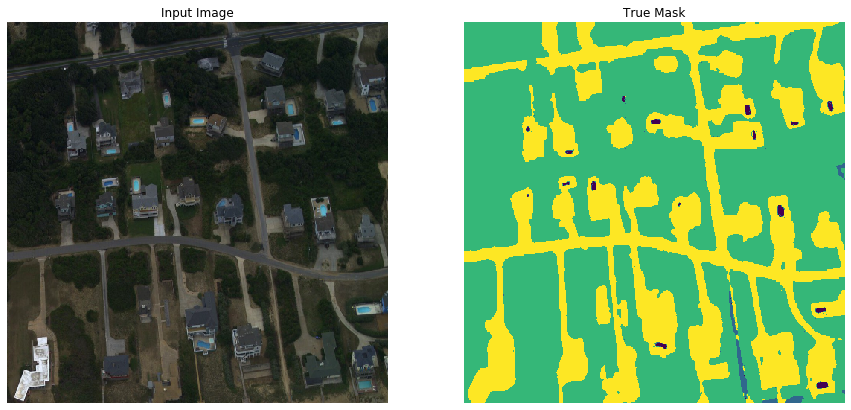

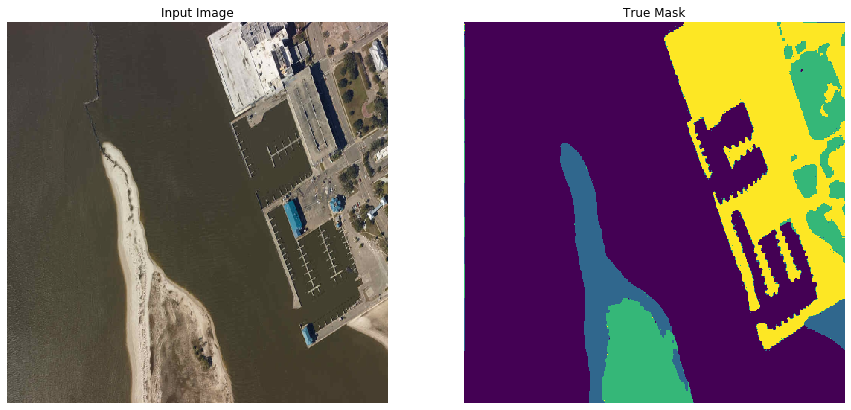

In [7]:
# plot results

#this function works for label encoding, not One hopt encoding
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    #print(sample_mask)
    display([sample_image, sample_mask])


In [8]:
imshape = (512,512,3)

#the model
#first we define the inputs, which is the shape of images defined in teh code blocks above 
inputs = layers.Input(imshape)

# 'Honey I shrunk the kids"'
# now we set up 4 blocks of comvolutons in the 'encoder' part
#block1
conv1 = layers.Conv2D(8, 2, activation = 'relu', strides=(1,1), padding="same")(inputs)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#block2
conv2 = layers.Conv2D(16, 2, activation = 'relu', strides=(1,1), padding="same")(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#block3
conv3 = layers.Conv2D(32, 3, activation = 'relu', strides=(1,1), padding="same")(pool2)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#block4
conv4 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1), padding="same")(pool3)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)


# we shrink as far as we are going to go...
#bottlneck
conv5 = layers.Conv2D(128, 2, activation = 'relu', strides=(1,1), padding="same")(pool4)

# # 'Honey I blew up the kids"... we upsample now
# #upblock 1
up6 = layers.UpSampling2D(2)(conv5)
conc6 = layers.concatenate([up6, conv4])
conv6 = layers.Conv2D(64, 3, activation = 'relu', strides=(1,1), padding="same")(conc6)

#upblock 2
up7 = layers.UpSampling2D(2)(conv6)
conc7 = layers.concatenate([up7, conv3])
conv7 = layers.Conv2D(32, 3, activation = 'relu', strides=(1,1), padding="same")(conc7)

#upblock 3
up8 = layers.UpSampling2D(2)(conv7)
conc8 = layers.concatenate([up8, conv2])
conv8 = layers.Conv2D(16, 3, activation = 'relu', strides=(1,1), padding="same")(conc8)

#upblock 4
up9 = layers.UpSampling2D(2)(conv8)
conc9 = layers.concatenate([up9, conv1])
conv9 = layers.Conv2D(4, 3, activation = 'relu', strides=(1,1), padding="same")(conc9)

#we define the outputs here
outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(conv9)


#combine the model together
model = Model(inputs, outputs)

#and print out the text summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  104         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  528         ['max_pooling2d[0][0]']      

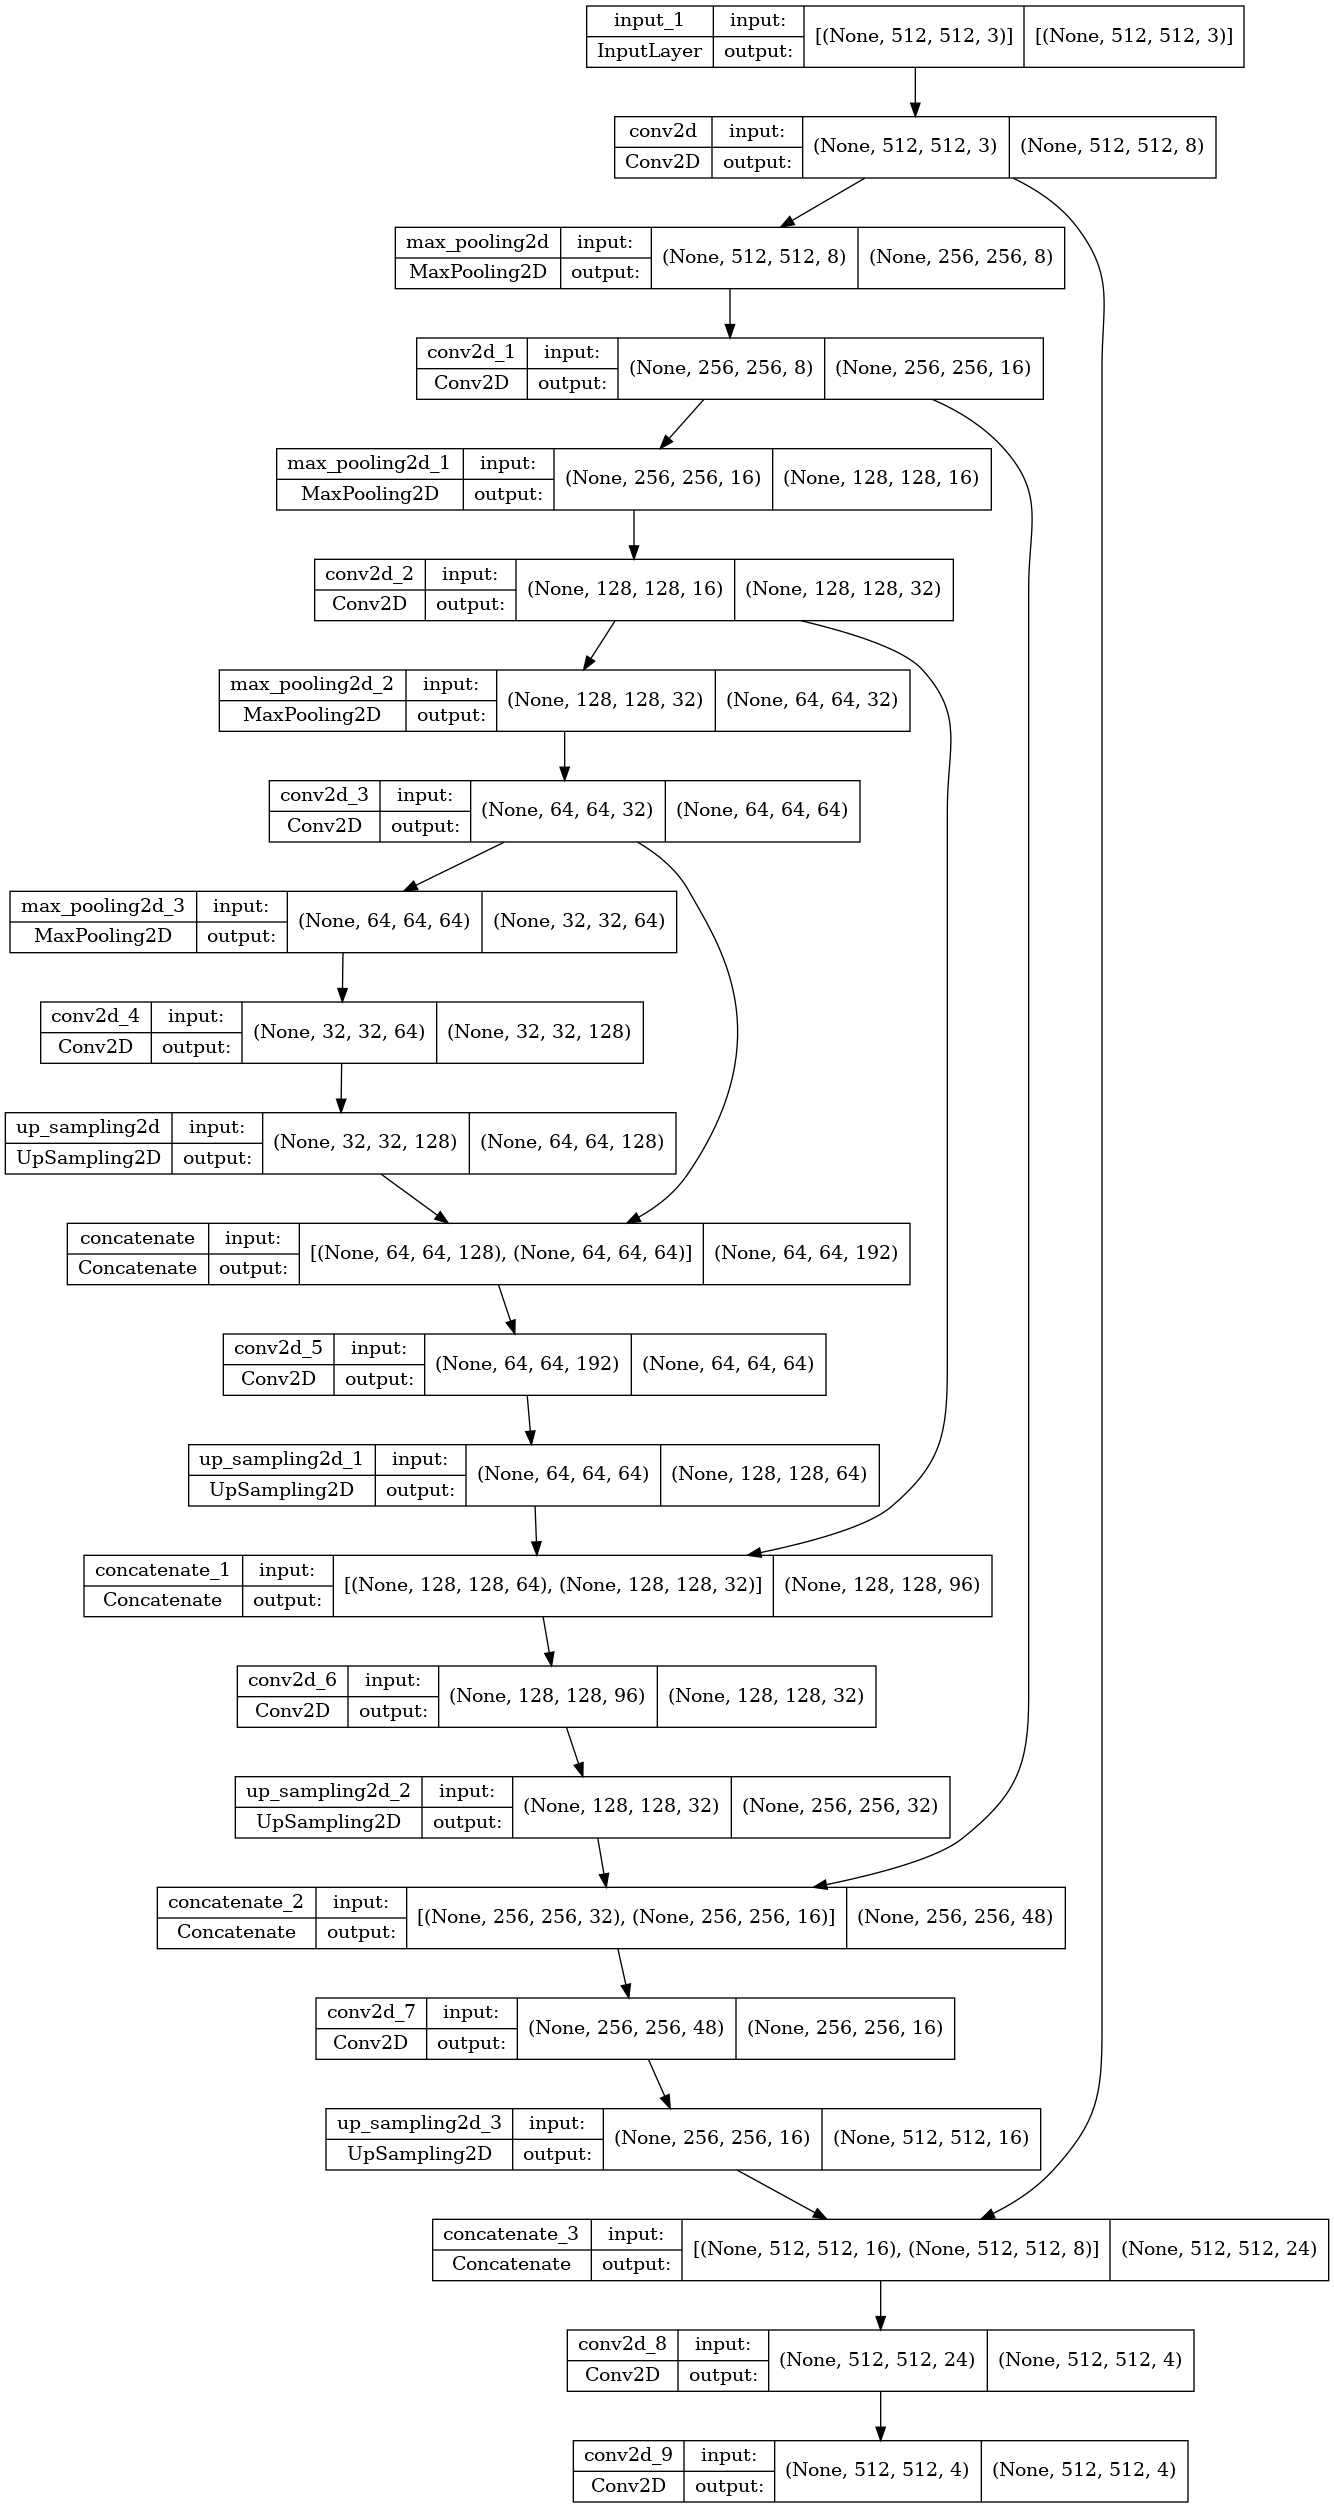

In [9]:
# here is a graphic summary of the model... you can see the downsampling, bottleneck, and upsampling, connected to each other via skip connections
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
#we compile the model, set a loss function, and also an optimizer. 

model.compile( loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.01))

In [11]:
# define a callback, which runs during training and does something for us. 
#This one looks at the training loss, and stops the training if the loss does 
#not improve from some number of epochs. Then it reverts to the best version of 
# the model, where loss was lowest

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [12]:
#lets now train the model! We can store all teh model output in 'history'.
# note that we are using the training generator for training data, the val 
# generator for validation data, we set the model to train for some number of epochs, 
# we tell teh network how many steps there are to get through the entire data set
# and we also give the network our callback to use.

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs= 3,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps =  val_size ,
                    callbacks =[callbacks])

Epoch 1/3
203/203 [==============================] - 127s 601ms/step - loss: 1.1406 - val_loss: 1.0580
Epoch 2/3
203/203 [==============================] - 131s 646ms/step - loss: 1.0117 - val_loss: 0.9918
Epoch 3/3
203/203 [==============================] - 132s 653ms/step - loss: 0.9738 - val_loss: 0.9787


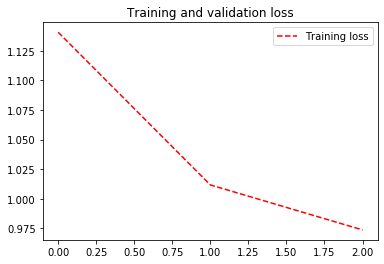

<Figure size 432x288 with 0 Axes>

In [13]:
#now that training is done, lets look at the metrics from training
%matplotlib inline

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r--', label='Training loss')
#plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

# # if you have another metric... i.e.,accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


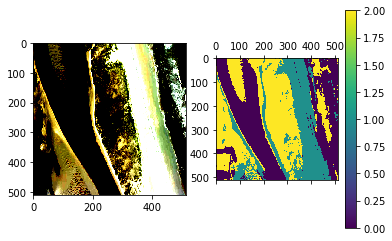

In [24]:
#lets look at the model prediction on a single image.

# here is the gdrive path to the image
imgp = 'data/images/C26047791-3_EBG.jpg'

#we pull the image and preprocess it — normalizing and making it a array/tensor
img = tf.keras.preprocessing.image.load_img(imgp,target_size = (512,512))
img = tf.keras.preprocessing.image.img_to_array(img)
img = standardize(img)
img = np.expand_dims(img,axis=0)

#We use the model to make a prediction on this image
pred = model.predict(img)

# we use argmax to get the labels for the image (recall the output of the 
# model is a tensor with shape of the image and then a depth equal to the 
# number of classes. this argmax and squeeze are here to collapse that).
lab = np.argmax(pred.squeeze(),-1)


#lets look at the model results and the image

imgUP = matplotlib.image.imread(imgp)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.squeeze())
labels = ax2.matshow(lab)
cax = fig.colorbar(labels, ax = ax2)
plt.show()

# water: 0; sand:1; veg : 2; dev : 3